# Mollow triplets 3

In [1]:
from functools import partial
import pdb

import pickle
import numpy as np
from scipy.optimize import minimize
from scipy.fftpack import fft, fftshift, fftfreq
from scipy.integrate import quad
from scipy.special import factorial, sinc
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import pysme.integrate as integ
import pysme.hierarchy as hier
import pysme.sparse_system_builder as ssb
import qinfo as qi
from qinfo import supops

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# define Qubit operators
sx = np.array([[0, 1], [1, 0]], dtype=np.complex)
sy = np.array([[0, -1.j], [1.j, 0]], dtype=np.complex)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex)
Id = np.eye(2, dtype=np.complex)
sp = (sx + 1.j * sy) / 2
sm = (sx - 1.j * sy) / 2
zero = np.zeros((2, 2), dtype=np.complex)

In [4]:
plt.style.use('../paper.mplstyle')

A coherent drive adds a Hamiltonian term.
\begin{align}
    d\rho&=dt[\beta^*L-\beta L^\dagger,\rho]+dt\mathcal{D}[L]\rho \\
    &=-idt[i\beta^*L-i\beta L^\dagger,\rho]+dt\mathcal{D}[L]\rho \\
    H_{\text{eff}}&=i\beta^*L-i\beta L^\dagger
\end{align}
For $L=\sqrt{\gamma}\sigma_-$, the Rabi frequency is $\Omega=2\sqrt{\gamma}|\beta|$.

(Carmichæl notates the Rabi frequency as $2\Omega$, so in his notation $\Omega=\sqrt{\gamma}|\beta|$.

In [5]:
def Heff_fn(beta, L):
    return 1.j*np.conj(beta)*L - 1.j*beta*L.conj().T

Try to reproduce plots from my thesis.

In [6]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

def xi_rect(t, a, b):
    return rect(t, a, b)/np.sqrt(b - a)

In [7]:
gamma = 1
beta = 16.j
r = np.log(2)
mu = 0
T = 4
xi_fn = partial(xi_rect, a=0, b=T)
Omega = 2*np.sqrt(gamma)*np.abs(beta)

In [8]:
Omega

In [9]:
rho0 = (Id - sz) / 2
S = Id
L = np.sqrt(gamma)*sm
H = zero

Parameters indicating how precisely we compute the correlators.

In [10]:
tau_final = 2**8
tau_samples = 2**12
taus = np.linspace(0, tau_final, tau_samples)

How long we evolve for to get steady-state.

In [11]:
times_ss = np.linspace(0, 32, 2**14)

Derived quantities useful for figuring out the scale of the frequency-domain steps.

In [12]:
frequencies = fftshift(fftfreq(taus.shape[0], np.diff(taus)[0]))
omegas = 2*np.pi*frequencies
d_omega = np.diff(omegas)[0]
Rabi_offset = 2*np.abs(beta) // d_omega

Functions for calculating the necessary correlation functions.

In [13]:
def calc_white_auto_corr(L, beta, r, mu, times_ss, taus, solve_ivp_kwargs=None):
    N = np.sinh(r)**2
    M_sq = -np.exp(2.j * mu) * np.sinh(r) * np.cosh(r)
    integrator = integ.UncondGaussIntegrator(L, M_sq, N, Heff_fn(beta, L))
    soln_ss = integrator.integrate(Id/2, times_ss)

    rho_ss = soln_ss.get_density_matrices(np.s_[-1])
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)

    L_0_taus = integrator.integrate_non_herm(rho_ss @ sp, taus, solve_ivp_kwargs=solve_ivp_kwargs)

    Expt_t_taus = L_0_taus.get_expectations(sm, hermitian=False)

    return rho_ss, Expt_t_taus - sp_ss * sm_ss

def calc_hier_auto_corr(xi_fn, L, r, mu, beta, m_max, taus, rho_ss, t, t0=0, timesteps=2**10,
                        solve_ivp_kwargs=None):
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)
    Id_field = np.eye(m_max + 1, dtype=np.complex)
    factory = hier.HierarchyIntegratorFactory(2, m_max)
    integrator = factory.make_uncond_integrator(xi_fn, Id, L, Heff_fn(beta, L), r, mu)
    times = np.linspace(t0, t, timesteps)
    soln_t = integrator.integrate(rho_ss, times)
    sp_ss_t = soln_t.get_expectations(sp, vac_rho(m_max), idx_slice=np.s_[-1], hermitian=False)
    rho_ss_t = soln_t.get_hierarchy_density_matrices(np.s_[-1])
    L_t_t = rho_ss_t @ np.kron(sp, Id_field)
    L_t_taus = integrator.integrate_hier_init_cond(L_t_t, taus + t,
                                                   solve_ivp_kwargs=solve_ivp_kwargs)
    Expt_t_taus = L_t_taus.get_expectations(sm, vac_rho(m_max), hermitian=False)
    soln_t_taus = integrator.integrate_hier_init_cond(rho_ss_t, taus + t,
                                                      solve_ivp_kwargs=solve_ivp_kwargs)
    sm_ss_t_taus = soln_t_taus.get_expectations(sm, vac_rho(m_max), hermitian=False)
    # Subtract off a bunch of stuff that gets rid of the delta
    return (Expt_t_taus - sp_ss_t * sm_ss - sp_ss * sm_ss_t_taus + sp_ss * sm_ss,
            sp_ss, sm_ss, sp_ss_t, sm_ss_t_taus)

def calc_hier_auto_corr_fock(xi_fn, L, r, mu, beta, m_max, taus, rho_ss, t, t0=0, timesteps=2**10,
                             solve_ivp_kwargs=None):
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)
    Id_field = np.eye(m_max + 1, dtype=np.complex)
    factory = hier.HierarchyIntegratorFactory(2, m_max)
    integrator = factory.make_uncond_integrator(xi_fn, Id, L, Heff_fn(beta, L), 0, 0)
    times = np.linspace(t0, t, timesteps)
    soln_t = integrator.integrate(rho_ss, times)
    sp_ss_t = soln_t.get_expectations(sp, sqz_rho(r, mu, m_max), idx_slice=np.s_[-1], hermitian=False)
    rho_ss_t = soln_t.get_hierarchy_density_matrices(np.s_[-1])
    L_t_t = rho_ss_t @ np.kron(sp, Id_field)
    L_t_taus = integrator.integrate_hier_init_cond(L_t_t, taus + t,
                                                   solve_ivp_kwargs=solve_ivp_kwargs)
    Expt_t_taus = L_t_taus.get_expectations(sm, sqz_rho(r, mu, m_max), hermitian=False)
    soln_t_taus = integrator.integrate_hier_init_cond(rho_ss_t, taus + t,
                                                      solve_ivp_kwargs=solve_ivp_kwargs)
    sm_ss_t_taus = soln_t_taus.get_expectations(sm, sqz_rho(r, mu, m_max), hermitian=False)
    # Subtract off a bunch of stuff that gets rid of the delta
    return (Expt_t_taus - sp_ss_t * sm_ss - sp_ss * sm_ss_t_taus + sp_ss * sm_ss,
            sp_ss, sm_ss, sp_ss_t, sm_ss_t_taus)

Turns out I had an error in my previous notebooks (which thankfully I think is irrelevant, since I didn't explore this parameter).
Yeoman and Barnett didn't specify the relationship between $M(\omega_A)$ and $\phi_s$.
I was left with the impression that $M(\omega_A)=e^{2i\phi_s}|M(\omega_A)|$, but I think that is not right, since for $\phi_L=0$, $\Phi=\pi\Rightarrow\phi_s=\pi$, and the fact that $\Phi=\pi$ gives different spectra means that $\phi_s=\pi$ can't be equivalent to $\phi_s=0$, like it currently is in my code.
The factor of whether to have a minus sign or not is also now bothering me...
I am so frustrated with how difficult it is to identify what all the different variables actually are in their paper.

I think there's also a mistake in the `deltas_degen_PA` fn, where I use $\gamma_c$ instead of $\gamma$.

In [15]:
def lam_mu(gamma_c, eps):
    lam = gamma_c + eps
    mu = gamma_c - eps
    return lam, mu

def N_degen_PA(omega, omega_A, lam, mu):
    return (lam**2 - mu**2)/4*(1/((omega - omega_A)**2 + mu**2)
                               - 1/((omega - omega_A)**2 + lam**2))
    
def mod_M_degen_PA(omega, omega_A, lam, mu):
    return (lam**2 - mu**2)/4*(1/((omega - omega_A)**2 + mu**2)
                               + 1/((omega - omega_A)**2 + lam**2))

def deltas_degen_PA(gamma_c, Omega, lam, mu):
    delta_mu = gamma_c*Omega*(lam**2 - mu**2)/(4*mu*(Omega**2 + mu**2))
    delta_lam = gamma_c*Omega*(lam**2 - mu**2)/(4*lam*(Omega**2 + mu**2))
    return delta_mu, delta_lam

def F_G(delta_mu, delta_lam, Phi):
    F_A = -(1j/4)*(delta_mu*(1 + np.cos(Phi))
                   - delta_lam*(1 - np.cos(Phi)))
    G_A = -(1/4)*(delta_mu + delta_lam)*np.sin(Phi)
    return F_A, G_A

def get_degen_PA_params(Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s):
    '''Get parameters for squeezing from degenerate PA

    Returns
    -------
    N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A

    '''
    lam, mu = lam_mu(gamma_c, eps)
    N_A = N_degen_PA(omega_A, omega_A, lam, mu)
    N_Om = N_degen_PA(omega_A + Omega, omega_A, lam, mu)
    mod_M_A = mod_M_degen_PA(omega_A, omega_A, lam, mu)
    mod_M_Om = mod_M_degen_PA(omega_A + Omega, omega_A, lam, mu)
    M_A = np.exp(1j*phi_s)*mod_M_A
    M_Om = np.exp(1j*phi_s)*mod_M_Om
    Delta_AL = omega_A - omega_L
    Phi = 2*phi_L - phi_s
    delta_mu, delta_lam = deltas_degen_PA(gamma_c, Omega, lam, mu)
    F_A, G_A = F_G(delta_mu, delta_lam, Phi)
    return N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A

def calc_quasi_markoff_degen_PA_auto_corr(
        gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s, times_ss, taus, solve_ivp_kwargs=None):
    N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A = get_degen_PA_params(
        Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s)
    integrator = integ.QuasiMarkoff2LvlIntegrator(
        gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A)
    soln_ss = integrator.integrate(Id/2, times_ss)

    rho_ss = soln_ss.get_density_matrices(np.s_[-1])
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)

    L_0_taus = integrator.integrate_non_herm(rho_ss @ sp, taus, solve_ivp_kwargs=solve_ivp_kwargs)

    Expt_t_taus = L_0_taus.get_expectations(sm, hermitian=False)
    return rho_ss, Expt_t_taus - sp_ss * sm_ss

In [16]:
def get_fluorescence_spectrum(auto_corr):
    fluorescence = fftshift(fft(auto_corr))
    return fluorescence

In [17]:
def gen_save_load_data(data_gen_method, fname, overwrite=False):
    '''Get the data returned by the generating method, running the method only if the data isn't already available.

    If the given filename exists, load and return the data from that file. Otherwise generate the data using the
    supplied method and save and return it.

    Useful for notebooks you imagine running multiple times, but where some of the data is expensive to generate
    and you want to save it to disk to be reloaded for future sessions.

    '''
    try:
        with open(fname, 'xb' if not overwrite else 'wb') as f:
            data = data_gen_method()
            pickle.dump(data, f)
    except FileExistsError:
        print('Data already exist.')
        with open(fname, 'rb') as f:
            data = pickle.load(f)
    return data

In [18]:
def gen_Expt_t_taus_wavepacket(
        xi_fn, L, r, mu, beta, m_max, taus, rho_ss_coh, t_final, solve_ivp_kwargs=None):
    '''Generate autocorrelation function for squeezed hierarchy

    Parameters
    ----------
    xi_fn : callable (float -> complex)
        Function returning the wavepacket amplitude at the evaluated time
    L : np.array
        Lindblad operator
    r : float
        Squeezing strength
    mu : float
        Squeezing angle
    beta : complex
        Drive amplitude
    m_max : int
        Hierarchy truncation level
    taus : np.array
        Times at which to evaluate the autocorrelation function
    rho_ss_coh : np.array
        The steady-state density matrix for a coherently driven atom
    t_final : float
        The fiducial time t to compute the auto correlation fn wrt: <sp(t)sm(t+tau)>
    solve_ivp_kwargs : dict
        Keyword arguments for the ``solve_ivp`` call made when integrating the hierarchy

    '''
    return calc_hier_auto_corr(xi_fn, L, r, mu, beta, m_max,
                               taus, rho_ss_coh, t=t_final,
                               solve_ivp_kwargs=solve_ivp_kwargs)

In [19]:
def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(n):
    ket = np.zeros(n + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

def make_squeezed_state_vec(r, mu, N, normalized=True):
    r'''Make a truncated squeezed-state vector.

    The squeezed-state vector is :math:`S(r,\mu)|0\rangle`. The truncated
    vector is renormalized by default.

    Parameters
    ----------
    N: positive integer
        The dimension of the truncated Hilbert space, basis {0, ..., N-1}
    r: real number
        Squeezing amplitude
    mu: real number
        Squeezing phase
    normalized: boolean
        Whether or not the truncated vector is renormalized

    Returns
    -------
    numpy.array
        Squeezed-state vector in the truncated Hilbert space, represented in the
        number basis

    '''
    ket = np.zeros(N, dtype=np.complex)
    for n in range(N//2):
        ket[2*n] = (1 / np.sqrt(np.cosh(r))) * ((-0.5 * np.exp(2.j * mu) * np.tanh(r))**n /
                                                factorial(n)) * np.sqrt(factorial(2 * n))
    return ket / np.linalg.norm(ket) if normalized else ket

def sqz_rho(r, mu, n):
    return rho_from_ket(make_squeezed_state_vec(r, mu, n + 1))

In [20]:
rho_ss_coh, delta_Expt_t_taus_coh = calc_white_auto_corr(L, beta, 0, 0, times_ss, taus,
                                                         solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

In [21]:
fluor_spec = get_fluorescence_spectrum(delta_Expt_t_taus_coh)

Text(0.5, 0, '$(\\omega-\\Omega)/\\Gamma$')

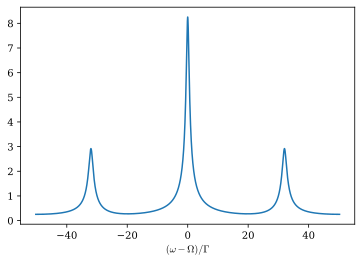

In [22]:
fig, ax = plt.subplots()
ax.plot(omegas, np.abs(fluor_spec))
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')

In [23]:
m_max = 12
t_final = 0.5
Expt_t_taus_wavepacket, _, _, _, _ = gen_save_load_data(partial(gen_Expt_t_taus_wavepacket, xi_fn=xi_fn, L=L, r=r,
                                                                mu=mu, beta=beta, m_max=m_max, taus=taus,
                                                                rho_ss_coh=rho_ss_coh, t_final=t_final,
                                                                solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9}),
                                                        '2020-06-25/Expt_t_taus_wavepacket.pickle')

Data already exist.


In [24]:
Expt_t_taus_wavepacket

array([ 4.99320613e-01+0.j,  1.51640406e-01+0.j,  8.04227137e-02+0.j, ...,
       -1.32136987e-08+0.j, -4.13006597e-09+0.j,  1.75379286e-08+0.j])

In [25]:
fluor_spec_wavepacket = get_fluorescence_spectrum(Expt_t_taus_wavepacket)

Text(0.5, 0, '$(\\omega-\\Omega)/\\Gamma$')

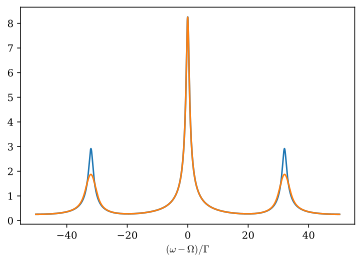

In [26]:
fig, ax = plt.subplots()
ax.plot(omegas, np.abs(fluor_spec))
ax.plot(omegas, np.abs(fluor_spec_wavepacket))
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')

In [27]:
def get_quasi_fluor_spec(
        gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s, times_ss, taus, solve_ivp_kwargs=None):
    _, Expt_t_taus = calc_quasi_markoff_degen_PA_auto_corr(gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s,
                                                           times_ss, taus, solve_ivp_kwargs)
    fluor_spec = get_fluorescence_spectrum(Expt_t_taus)
    return fluor_spec

In [28]:
def get_quasi_cost_fn(target_fluor_spec, gamma, beta, omega_A, omega_L, times_ss, taus, solve_ivp_kwargs=None):
    Omega = 2*np.abs(beta)
    phi_L = np.angle(beta)
    def calculate_cost(x):
        gamma_c, eps, phi_s = x
        quasi_fluor_spec = get_quasi_fluor_spec(
            gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s, times_ss, taus)
        return np.sum(np.abs(quasi_fluor_spec - target_fluor_spec)**2)
    return calculate_cost

In [29]:
omega_A = 0
omega_L = 0
quasi_cost_fn = get_quasi_cost_fn(fluor_spec_wavepacket, gamma, beta, omega_A, omega_L, times_ss, taus)

In [34]:
fname = 'quasi_soln_x.npy'
try:
    with open(fname, 'xb') as f:
        gamma_c = 1
        eps = 0.5
        phi_s = 0
        quasi_soln = minimize(quasi_cost_fn, x0=np.array([gamma_c, eps, phi_s]))
        np.save(f, quasi_soln.x)
except FileExistsError:
    print('Data already exist.')
    with open(fname, 'rb') as f:
        quasi_soln_x = np.load(f)

Data already exist.


In [35]:
quasi_soln_x

array([ 5.72914474e-01,  1.35050959e+00, -1.34643026e-05])

In [36]:
Omega = 2*np.abs(beta)
phi_L = np.angle(beta)
quasi_soln_spec = get_quasi_fluor_spec(
    gamma, Omega, omega_A, omega_L, quasi_soln_x[0], quasi_soln_x[1], phi_L, quasi_soln_x[2], times_ss, taus)

Text(0.5, 0, '$(\\omega-\\Omega)/\\Gamma$')

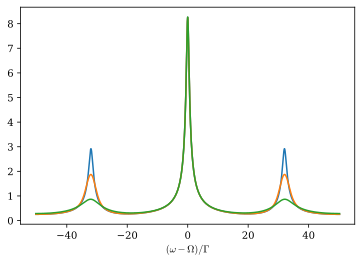

In [37]:
fig, ax = plt.subplots()
ax.plot(omegas, np.abs(fluor_spec))
ax.plot(omegas, np.abs(fluor_spec_wavepacket))
ax.plot(omegas, np.abs(quasi_soln_spec))
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')

In [41]:
Omega = 2*np.abs(beta)
phi_L = np.angle(beta)
quasi_spec_0 = get_quasi_fluor_spec(
    gamma, Omega, omega_A, omega_L, quasi_soln_x[0], 2*quasi_soln_x[1], phi_L, quasi_soln_x[2], times_ss, taus)

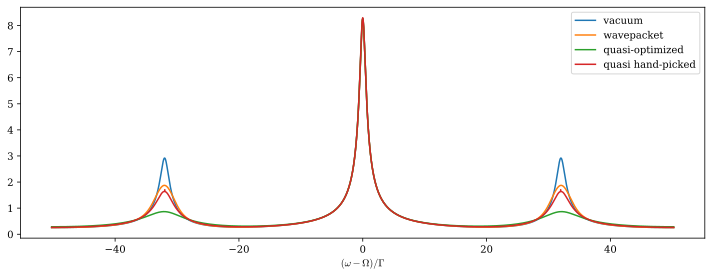

In [42]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(omegas, np.abs(fluor_spec), label='vacuum')
ax.plot(omegas, np.abs(fluor_spec_wavepacket), label='wavepacket')
ax.plot(omegas, np.abs(quasi_soln_spec), label='quasi-optimized')
ax.plot(omegas, np.abs(quasi_spec_0), label='quasi hand-picked')
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')
ax.legend()
plt.tight_layout()

In [43]:
np.sum(np.abs(quasi_soln_spec - fluor_spec_wavepacket)**2)

In [44]:
np.sum(np.abs(quasi_spec_0 - fluor_spec_wavepacket)**2)

In [38]:
fname = 'quasi_soln_2_x.npy'
try:
    with open(fname, 'xb') as f:
        gamma_c = 1
        eps = 0.5
        phi_s = 0
        quasi_soln_2 = minimize(quasi_cost_fn, x0=np.array([quasi_soln_x[0], 2*quasi_soln_x[1], quasi_soln_x[2]]))
        np.save(f, quasi_soln_2.x)
except FileExistsError:
    print('Data already exist.')
    with open(fname, 'rb') as f:
        quasi_soln_2_x = np.load(f)

Data already exist.


Let's make two changes.
First, ignore the phase (we know how we're squeezing it), so just adjust the bandwidth and strength.
Then, use Nelder-Mead to optimise (because whatever BFGS or something it's using isn't working very well).

In [45]:
def get_quasi_cost_fn_known_phi_s(target_fluor_spec, gamma, beta, omega_A, omega_L, phi_s, times_ss, taus, solve_ivp_kwargs=None):
    Omega = 2*np.abs(beta)
    phi_L = np.angle(beta)
    def calculate_cost(x):
        gamma_c, eps = x
        quasi_fluor_spec = get_quasi_fluor_spec(
            gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s, times_ss, taus)
        return np.sum(np.abs(quasi_fluor_spec - target_fluor_spec)**2)
    return calculate_cost

In [46]:
omega_A = 0
omega_L = 0
phi_s = 0
quasi_cost_fn_known_phi_s = get_quasi_cost_fn_known_phi_s(
    fluor_spec_wavepacket, gamma, beta, omega_A, omega_L, phi_s, times_ss, taus)

In [47]:
fname = 'quasi_soln_3_x.npy'
try:
    with open(fname, 'xb') as f:
        gamma_c = 1
        eps = 0.5
        phi_s = 0
        quasi_soln_3 = minimize(quasi_cost_fn_known_phi_s, x0=np.array([quasi_soln_x[0], 2*quasi_soln_x[1]]),
                                method='Nelder-Mead')
        np.save(f, quasi_soln_3.x)
except FileExistsError:
    print('Data already exist.')
    with open(fname, 'rb') as f:
        quasi_soln_3_x = np.load(f)

Data already exist.


`N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A`

In [48]:
Omega = 2*np.abs(beta)
phi_L = np.angle(beta)
omega_A = 0
omega_L = 0
phi_s = 0
get_degen_PA_params(Omega, omega_A, omega_L, quasi_soln_3_x[0], quasi_soln_3_x[1], phi_L, phi_s)

(0.09625249411389006,
 8.67674137985729e-06,
 (0.3248338602070826+0j),
 (0.0029456436759557284+0j),
 0,
 0.003110605032506895j,
 6.804844123982667e-20)

In [49]:
np.arcsinh(np.sqrt(get_degen_PA_params(Omega, omega_A, omega_L, quasi_soln_3_x[0], quasi_soln_3_x[1], phi_L, phi_s)[0]))

In [50]:
np.log(2)

In [51]:
Omega = 2*np.abs(beta)
phi_L = np.angle(beta)
phi_s = 0
quasi_soln_3_spec = get_quasi_fluor_spec(
    gamma, Omega, omega_A, omega_L, quasi_soln_3_x[0], quasi_soln_3_x[1], phi_L, phi_s, times_ss, taus)

In [52]:
_, Expt_t_taus = calc_quasi_markoff_degen_PA_auto_corr(gamma, Omega, omega_A, omega_L, quasi_soln_3_x[0], quasi_soln_3_x[1], phi_L, 0,
                                                       times_ss, taus, solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

In [53]:
quasi_soln_3_spec_precise = get_fluorescence_spectrum(Expt_t_taus)

In [54]:
Expt_t_taus_padded = np.hstack([Expt_t_taus, np.zeros(3*Expt_t_taus.shape[0], Expt_t_taus.dtype)])

In [55]:
quasi_soln_3_spec_padded = get_fluorescence_spectrum(Expt_t_taus_padded)

In [56]:
frequencies_padded = fftshift(fftfreq(4*taus.shape[0], np.diff(taus)[0]))
omegas_padded = 2*np.pi*frequencies_padded
d_omega_padded = np.diff(omegas_padded)[0]
Rabi_offset_padded = 2*np.abs(beta) // d_omega_padded

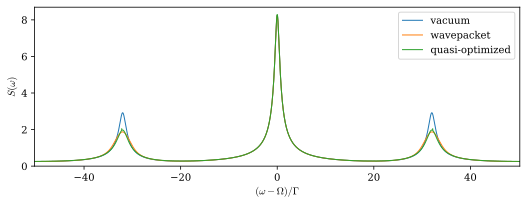

In [57]:
fig, ax = plt.subplots(figsize=(7.5,3))
ax.plot(omegas, np.abs(fluor_spec), label='vacuum', linewidth=1)
ax.plot(omegas, np.abs(fluor_spec_wavepacket), label='wavepacket', linewidth=1)
ax.plot(omegas, np.abs(quasi_soln_3_spec), label='quasi-optimized', linewidth=1)
ax.legend()
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')
ax.set_ylabel(r'$S(\omega)$')
ax.set_xlim(omegas[0], omegas[-1])
ax.set_ylim(0, None)
plt.tight_layout()
plt.savefig('quasi-markoff-opt-mollow.pdf')

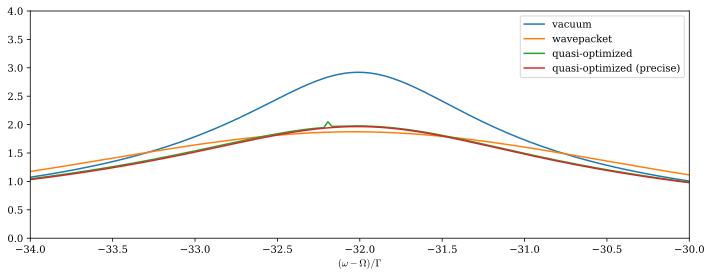

In [58]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(omegas, np.abs(fluor_spec), label='vacuum')
ax.plot(omegas, np.abs(fluor_spec_wavepacket), label='wavepacket')
ax.plot(omegas, np.abs(quasi_soln_3_spec), label='quasi-optimized')
ax.plot(omegas, np.abs(quasi_soln_3_spec_precise), label='quasi-optimized (precise)')
ax.legend()
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')
ax.set_ylim([0, 4])
ax.set_xlim([-34, -30])
plt.tight_layout()

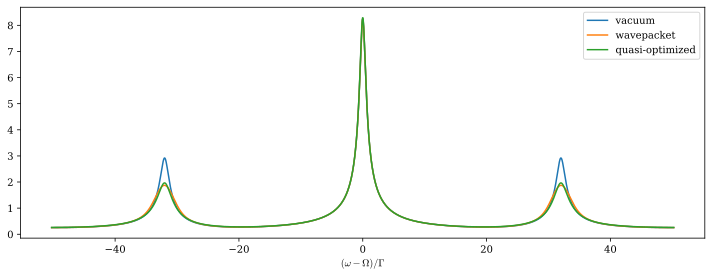

In [59]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(omegas, np.abs(fluor_spec), label='vacuum')
ax.plot(omegas, np.abs(fluor_spec_wavepacket), label='wavepacket')
ax.plot(omegas, np.abs(quasi_soln_3_spec_precise), label='quasi-optimized')
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')
ax.legend()
plt.tight_layout()
plt.savefig('mollow-triplet-quasi-optimized.pdf')

In [60]:
fname = 'fluorsecence-spectra.pickle'
try:
    with open(fname, 'xb') as f:
        pickle.dump({'omegas': omegas,
                     'vacuum': fluor_spec,
                     'wavepacket': fluor_spec_wavepacket,
                     'quasi-optimized': quasi_soln_3_spec_precise},
                    f)
except FileExistsError:
    print('Data already exist.')

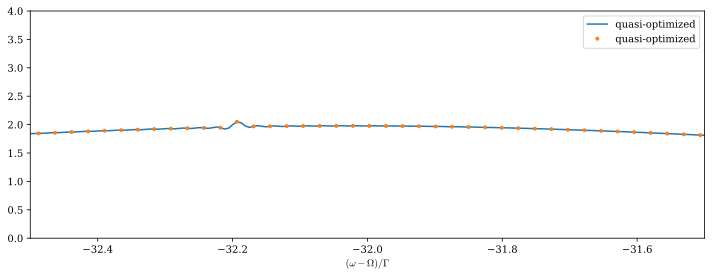

In [159]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(omegas_padded, np.abs(quasi_soln_3_spec_padded), label='quasi-optimized')
ax.plot(omegas, np.abs(quasi_soln_3_spec), label='quasi-optimized', linewidth=0, marker='.')
ax.legend()
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')
ax.set_ylim([0, 4])
ax.set_xlim([-32.5, -31.5])
plt.tight_layout()

## More resolution

See if those artefacts disappear when I use more temporal resolution.

Increasing the final time by a factor of 2 and the number of samples by a factor of 4 reduced the peaks, but it also changed the values of the spectrum.
Made it up to twice as large, but not consistently.
Why would I see this discrepency?
If I increast the number of samples proportionately with the final time, then things look the same (with the peak artefats reduced).

Actually, this artefact doesn't seem to consistently go away as we make things bigger.
It actually becomes more of a problem when I bump both up by a factor of 4.

It looks like that, as I continuously double the number of sample points, the new spectrum is approximately double the old spectrum, and the dips of deviation from the factor of two grow smaller, so it looks like we're converging to a consistent spectrum, but this takes an enourmous amount of data...

Maybe it is worth just using analytics, if I can figure out what Yeoman and Barnett mean...

Now I'm also worried, though, that we don't have enough data for the wavepacket spectra...

In [187]:
spectra = []
for n in range(10, 16):
    tau_final_2 = 2**8
    tau_samples_2 = 2**n
    taus_2 = np.linspace(0, tau_final_2, tau_samples_2)

    frequencies_2 = fftshift(fftfreq(taus_2.shape[0], np.diff(taus_2)[0]))
    omegas_2 = 2*np.pi*frequencies_2
    d_omega_2 = np.diff(omegas_2)[0]
    Rabi_offset_2 = 2*np.abs(beta) // d_omega_2

    quasi_soln_3_spec_2 = get_quasi_fluor_spec(
        gamma, Omega, omega_A, omega_L, quasi_soln_3_x[0], quasi_soln_3_x[1], phi_L, phi_s, times_ss, taus_2, solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})
    spectra.append((omegas_2, quasi_soln_3_spec_2))

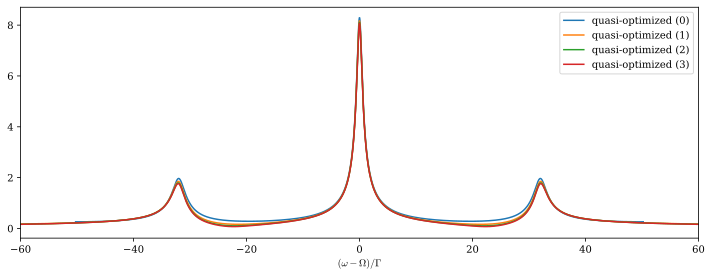

In [191]:
fig, ax = plt.subplots(figsize=(10,4))
for n, (oms, spec) in enumerate(spectra[2:]):
    ax.plot(oms, np.abs(spec)/2**n, label='quasi-optimized ({})'.format(n))
ax.legend()
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')
ax.set_xlim(-60, 60)
#ax.set_ylim(0.2, 0.25)
plt.tight_layout()

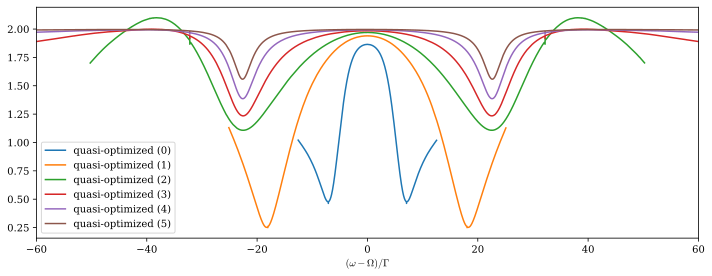

In [168]:
fig, ax = plt.subplots(figsize=(10,4))
for n, ((omsA, specA), (omsB, specB)) in enumerate(zip(spectra[1:], spectra[:-1])):
    spec_interp = interp1d(omsA, specA)
    ax.plot(omsB, np.abs(spec_interp(omsB))/np.abs(specB), label='quasi-optimized ({})'.format(n))
ax.legend()
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')
ax.set_xlim(-1, 1)
plt.tight_layout()

In [161]:
spectral_pairs = list(zip(spectra[1:], spectra[:-1]))

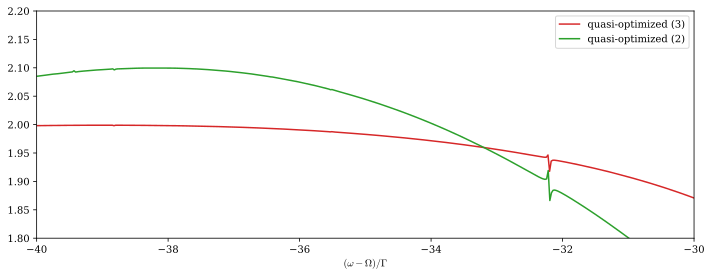

In [166]:
fig, ax = plt.subplots(figsize=(10,4))
n = 3
(omsA, specA), (omsB, specB) = spectral_pairs[n]
spec_interp = interp1d(omsA, specA)
ax.plot(omsB, np.abs(spec_interp(omsB))/np.abs(specB), label='quasi-optimized ({})'.format(n), color='C{}'.format(n))
n = 2
(omsA, specA), (omsB, specB) = spectral_pairs[n]
spec_interp = interp1d(omsA, specA)
ax.plot(omsB, np.abs(spec_interp(omsB))/np.abs(specB), label='quasi-optimized ({})'.format(n), color='C{}'.format(n))
ax.legend()
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')
ax.set_xlim(-40, -30)
ax.set_ylim(1.8, 2.2)
plt.tight_layout()

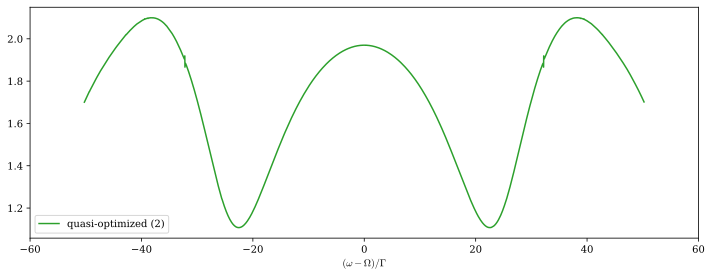

In [164]:
fig, ax = plt.subplots(figsize=(10,4))
n = 2
(omsA, specA), (omsB, specB) = spectral_pairs[n]
spec_interp = interp1d(omsA, specA)
ax.plot(omsB, np.abs(spec_interp(omsB))/np.abs(specB), label='quasi-optimized ({})'.format(n), color='C{}'.format(n))
ax.legend()
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')
ax.set_xlim(-60, 60)
plt.tight_layout()

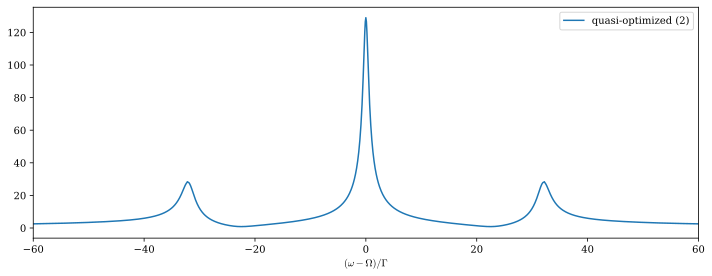

In [122]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(omegas_2, np.abs(quasi_soln_3_spec_2), label='quasi-optimized (2)')
ax.legend()
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')
ax.set_xlim(-60, 60)
plt.tight_layout()

In [117]:
interpolator = interp1d(omegas_2, quasi_soln_3_spec_2)

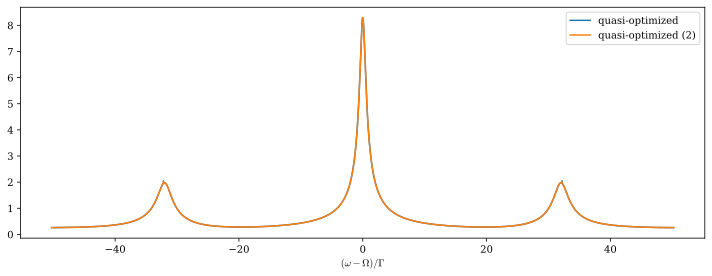

In [101]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(omegas, np.abs(quasi_soln_3_spec), label='quasi-optimized')
ax.plot(omegas, np.abs(interpolator(omegas)), label='quasi-optimized (2)')
ax.legend()
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')
plt.tight_layout()

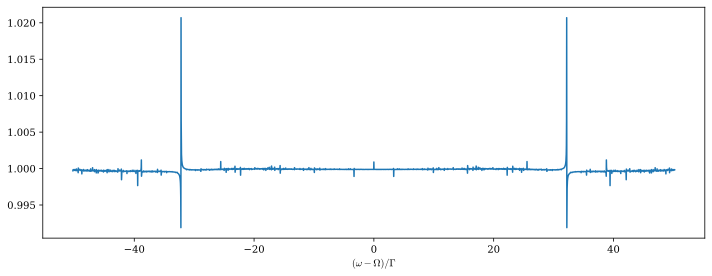

In [102]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(omegas, np.abs(quasi_soln_3_spec)/np.abs(interpolator(omegas)))
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')
plt.tight_layout()

## Do it analytically

In [136]:
def S_quasi_degen(omega, C1, CR, CI, lam1, omega_L, sigma, Omega_p):
    '''Equation (76) from Yeoman and Barnett

    '''
    L0 = -(1/np.pi)*((C1*lam1)/(lam1**2 + (omega - omega_L)**2))
    Lp = -(1/np.pi)*((CR*sigma + C1*(omega - omega_L + Omega_p))/(sigma**2 + (omega - omega_L + Omega_p)**2))
    Lm = -(1/np.pi)*((CR*sigma + C1*(omega - omega_L - Omega_p))/(sigma**2 + (omega - omega_L - Omega_p)**2))
    return L0 + Lp + Lm

def ss_quasi_degen(gamma_0, gamma, gamma_Omega, Omega, delta):
    '''Equations (68-70) from Yeoman and Barnett

    '''
    return {
        'x': 0,
        'z': -(gamma_0*gamma)/(gamma_0*(gamma_0 + gamma_Omega) + Omega*(Omega + 2*delta)),
        'y': -((1/2)*gamma*(Omega + 2*delta))/(gamma_0*(gamma_0 + gamma_Omega) + Omega*(Omega + 2*delta))
    }

def spectrum_coeffs_quasi_degen(sigx_ss, sigy_ss, sigz_ss, lam2, lam3, gamma_0, gamma_Omega, Omega, delta, gamma):
    '''Equations (72-75) from Yeoman and Barnett

    '''
    return [
        np.abs(sigy_ss)**2,
        (1/4)*(1 + np.abs(sigz_ss)),
        ((1/4)*(1 + np.abs(sigz_ss))*(lam2 + gamma_0 + gamma_Omega))/(lam2 - lam3)
        -((((1/2)*Omega + delta)*np.abs(sigy_ss))/(lam2 - lam3))*(1 + gamma/lam2),
        ((1/4)*(1 + np.abs(sigz_ss))*(lam3 + gamma_0 + gamma_Omega))/(lam3 - lam2)
        -((((1/2)*Omega + delta)*np.abs(sigy_ss))/(lam3 - lam2))*(1 + gamma/lam3)
    ]

def deltas_quasi_degen(gamma, Omega, lam, mu):
    '''Equations (46-47) from Yeoman and Barnett

    '''
    return {
        'mu': gamma*Omega*((lam**2 - mu**2)/4)*(1/(mu*(Omega**2 + mu**2))),
        'lam': gamma*Omega*((lam**2 - mu**2)/4)*(1/(lam*(Omega**2 + lam**2)))
    }

def gammas_quasi_degen(gamma, N_A, N_Om, M_A, M_Om, Phi):
    return {
        0: gamma*(N_A - np.abs(M_A)*np.cos(Phi) + (1/2)),
        'Omega': gamma*(N_Om + np.abs(M_Om)*np.cos(Phi) + (1/2))
    }

def generic_incoh_spectrum(omega, C1, C2, C3, lam1, lam2, lam3, omega_L):
    L1 = -(1/np.pi)*((C1*lam1)/(lam1**2 + (omega - omega_L)**2))
    L2 = -(1/np.pi)*((C2*lam2)/(lam2**2 + (omega - omega_L)**2))
    L3 = -(1/np.pi)*((C3*lam3)/(lam3**2 + (omega - omega_L)**2))
    return L1 + L2 + L3

In [135]:
class SpecFn:
    def __init__(self, gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s):
        N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A = get_degen_PA_params(Omega, omega_A, omega_L,
                                                                       gamma_c, eps, phi_L, phi_s)
        Phi = 2*phi_L - phi_s
        gammas = gammas_quasi_degen(gamma, N_A, N_Om, M_A, M_Om, Phi)
        lam, mu = lam_mu(gamma_c, eps)
        deltas = deltas_quasi_degen(gamma, Om)
        if Phi == 0:
            delta = deltas['mu']
        else:
            # Should be that Phi = pi here
            delta = -deltas['lam']
        ss = ss_quasi_degen(gammas[0], gamma, gammas['Omega'], Omega, delta)

    def __call__(self, omega):
        return S_quasi_degen(omega, self.C1, self.C2, self.C3, self.lam1, self.lam2, self.lam3, omega_L)